# Kaggle Facial Keypoint DetectionをKerasで実装

In [1]:
# 各種モジュールのimport
import os
import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

In [2]:
# training dataとtest dataの定義
FTRAIN = 'data/training.csv'
FTEST = 'data/test.csv'

In [3]:
# データのload用関数
def load(test=False, cols=None):
    """
    testがTrueの場合はFTESTからデータを読み込み、Falseの場合はFTRAINから読み込む
    colsにリストが渡された場合にはそのカラムに関するデータのみ返す
    """

    # ファイル名を決定
    fname = FTEST if test else FTRAIN
    # pandasのdataframeでcsvを読み込み
    df = read_csv(os.path.expanduser(fname)) 

    # スペースで句切られているピクセル値をnumpy arrayに変換
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # カラムに関連するデータのみを抽出
        df = df[list(cols) + ['Image']]

    print(df.count())  # カラム毎に値が存在する行数を出力
    df = df.dropna()  # データが欠けている行は捨てる

    X = np.vstack(df['Image'].values) / 255.  # 0から1の値に変換
    X = X.astype(np.float32)

    if not test:  # ラベルが存在するのはFTRAINのみ
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # -1から1の値に変換
        X, y = shuffle(X, y, random_state=42)  # データをシャッフル
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

### ------上記のload関数の中身を実行してみる------

In [4]:
fname = FTRAIN
os.path.expanduser(fname) # path内に'~'があれば、ホームディレクトリのpathに置き換える

'data/training.csv'

In [5]:
# pandasのdataframeでcsvを読み込み
# このデータは最終列が入力で、１列目〜(最終列-1)列目が教師データ
# 入力は96×96の画像データ
df = read_csv(os.path.expanduser(fname))
df.tail(5)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
7044,67.402546,31.842551,29.746749,38.632942,NaN,NaN,NaN,NaN,NaN,NaN,...,67.029093,NaN,NaN,NaN,NaN,NaN,NaN,50.426637,79.683921,71 74 85 105 116 128 139 150 170 187 201 209 2...
7045,66.134400,38.365501,30.478626,39.950198,NaN,NaN,NaN,NaN,NaN,NaN,...,66.626011,NaN,NaN,NaN,NaN,NaN,NaN,50.287397,77.983023,60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...
7046,66.690732,36.845221,31.666420,39.685042,NaN,NaN,NaN,NaN,NaN,NaN,...,67.515161,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,78.117120,74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...
7047,70.965082,39.853666,30.543285,40.772339,NaN,NaN,NaN,NaN,NaN,NaN,...,66.724988,NaN,NaN,NaN,NaN,NaN,NaN,50.065186,79.586447,254 254 254 254 254 238 193 145 121 118 119 10...
7048,66.938311,43.424510,31.096059,39.528604,NaN,NaN,NaN,NaN,NaN,NaN,...,73.033339,NaN,NaN,NaN,NaN,NaN,NaN,45.900480,82.773096,53 62 67 76 86 91 97 105 105 106 107 108 112 1...


In [6]:
# 'image'列はスペース区切りのデータが入っているのでarrayに変換
# lambda式　：　無名関数生成式
# np.fromstring　：　文字列から1次元arrayを作成
df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))
df.tail(5)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
7044,67.402546,31.842551,29.746749,38.632942,NaN,NaN,NaN,NaN,NaN,NaN,...,67.029093,NaN,NaN,NaN,NaN,NaN,NaN,50.426637,79.683921,"[71.0, 74.0, 85.0, 105.0, 116.0, 128.0, 139.0,..."
7045,66.134400,38.365501,30.478626,39.950198,NaN,NaN,NaN,NaN,NaN,NaN,...,66.626011,NaN,NaN,NaN,NaN,NaN,NaN,50.287397,77.983023,"[60.0, 60.0, 62.0, 57.0, 55.0, 51.0, 49.0, 48...."
7046,66.690732,36.845221,31.666420,39.685042,NaN,NaN,NaN,NaN,NaN,NaN,...,67.515161,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,78.117120,"[74.0, 74.0, 74.0, 78.0, 79.0, 79.0, 79.0, 81...."
7047,70.965082,39.853666,30.543285,40.772339,NaN,NaN,NaN,NaN,NaN,NaN,...,66.724988,NaN,NaN,NaN,NaN,NaN,NaN,50.065186,79.586447,"[254.0, 254.0, 254.0, 254.0, 254.0, 238.0, 193..."
7048,66.938311,43.424510,31.096059,39.528604,NaN,NaN,NaN,NaN,NaN,NaN,...,73.033339,NaN,NaN,NaN,NaN,NaN,NaN,45.900480,82.773096,"[53.0, 62.0, 67.0, 76.0, 86.0, 91.0, 97.0, 105..."


In [7]:
# 非欠損の行数を列ごとに表示
print(df.count())

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

In [8]:
# 欠損の行を削除
df = df.dropna()
print(df.count())

left_eye_center_x            2140
left_eye_center_y            2140
right_eye_center_x           2140
right_eye_center_y           2140
left_eye_inner_corner_x      2140
left_eye_inner_corner_y      2140
left_eye_outer_corner_x      2140
left_eye_outer_corner_y      2140
right_eye_inner_corner_x     2140
right_eye_inner_corner_y     2140
right_eye_outer_corner_x     2140
right_eye_outer_corner_y     2140
left_eyebrow_inner_end_x     2140
left_eyebrow_inner_end_y     2140
left_eyebrow_outer_end_x     2140
left_eyebrow_outer_end_y     2140
right_eyebrow_inner_end_x    2140
right_eyebrow_inner_end_y    2140
right_eyebrow_outer_end_x    2140
right_eyebrow_outer_end_y    2140
nose_tip_x                   2140
nose_tip_y                   2140
mouth_left_corner_x          2140
mouth_left_corner_y          2140
mouth_right_corner_x         2140
mouth_right_corner_y         2140
mouth_center_top_lip_x       2140
mouth_center_top_lip_y       2140
mouth_center_bottom_lip_x    2140
mouth_center_b

In [9]:
# np.vstack : 列方向にarrayをつなげる
# 0から1の値に変換（'image'列データは0~255）
X = np.vstack(df['Image'].values) / 255.  
print(X)

[[ 0.93333333  0.9254902   0.92941176 ...,  0.2745098   0.29411765
   0.35294118]
 [ 0.85882353  0.84313725  0.8        ...,  0.00392157  0.00392157
   0.00392157]
 [ 0.56470588  0.55686275  0.62352941 ...,  0.30588235  0.30588235
   0.30196078]
 ..., 
 [ 0.12156863  0.15686275  0.18431373 ...,  0.15294118  0.2         0.29411765]
 [ 0.02745098  0.00392157  0.01960784 ...,  0.70196078  0.69411765
   0.22352941]
 [ 0.26666667  0.0745098   0.0745098  ...,  0.49019608  0.48627451
   0.46666667]]


In [10]:
# np.astype : 別のデータ型のndarrayに変換
# np.float32 : 32bit浮動小数点数
X = X.astype(np.float32)

In [11]:
# 教師データの整理
y = df[df.columns[:-1]].values
 # -1から1の値に変換
y = (y - 48) / 48 
 # データをシャッフル
X, y = shuffle(X, y, random_state=42) 
# 型を32bit floatに変換
y = y.astype(np.float32)

### -------------------------------------------------------

In [12]:
# load関数の実行
X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

## モデル１：中間層が１層のモデル

In [13]:
# 各種モジュールのimport
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

Using Theano backend.


In [14]:
# Kerasモデルの設定
model = Sequential()
model.add(Dense(100, input_dim=9216)) # 中間層のニューロン数は100, 入力の次元は9216
model.add(Activation('relu')) # 活性化関数はReLU
model.add(Dense(30)) # 出力の次元は30

In [15]:
# 確率的勾配法による学習
sgd = SGD(lr='0.01', momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd) # 誤差関数は二乗誤差
hist = model.fit(X, y, nb_epoch=100, validation_split=0.2)

Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 0s - loss: 0.0450 - val_loss: 0.0155
Epoch 2/100
1712/1712 [==============================] - 0s - loss: 0.0142 - val_loss: 0.0134
Epoch 3/100
1712/1712 [==============================] - 0s - loss: 0.0118 - val_loss: 0.0122
Epoch 4/100
1712/1712 [==============================] - 0s - loss: 0.0105 - val_loss: 0.0118
Epoch 5/100
1712/1712 [==============================] - 0s - loss: 0.0098 - val_loss: 0.0096
Epoch 6/100
1712/1712 [==============================] - 1s - loss: 0.0091 - val_loss: 0.0096
Epoch 7/100
1712/1712 [==============================] - 0s - loss: 0.0085 - val_loss: 0.0095
Epoch 8/100
1712/1712 [==============================] - 0s - loss: 0.0082 - val_loss: 0.0090
Epoch 9/100
1712/1712 [==============================] - 0s - loss: 0.0077 - val_loss: 0.0083
Epoch 10/100
1712/1712 [==============================] - 0s - loss: 0.0075 - val_loss: 0.0083
Epoch 11/100

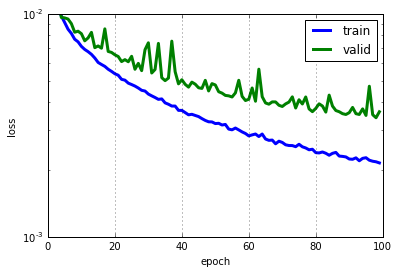

In [17]:
# 学習曲線をplot
from matplotlib import pyplot
% matplotlib inline
pyplot.plot(hist.history['loss'], linewidth=3, label='train')
pyplot.plot(hist.history['val_loss'], linewidth=3, label='valid')
pyplot.grid()
pyplot.legend()
pyplot.xlabel('epoch')
pyplot.ylabel('loss')
pyplot.ylim(1e-3, 1e-2)
pyplot.yscale('log')
pyplot.show()

### 学習したモデルを使ってkeypointsを出力

In [18]:
# test用データのload
# 関数load()は、X, yが出力されるので、いらないyは_で受ける
X_test, _ = load(test=True)
y_test = model.predict(X_test)

ImageId    1783
Image      1783
dtype: int64


In [24]:
def plot_sample(x, y, axis):
    # 顔データの整形
    img = x.reshape(96, 96)
    # numpy arrayをimageとして出力
    axis.imshow(img, cmap='gray')
    # keypointをプロット
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

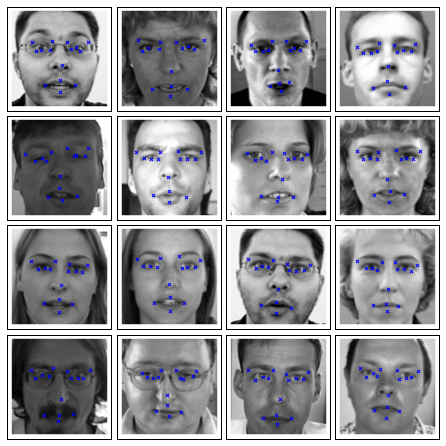

In [25]:
# keypointの出力
fig = pyplot.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    # subplot内に各々プロットをする
    axis = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_test[i], axis)

pyplot.show()

In [26]:
# 学習モデルの保存
json_string = model.to_json()
# モデルの構造説明のみをjson形式で保存
open('model1_architecture.json', 'w').write(json_string)
# weightの情報を保存
model.save_weights('model1_weights.h5')

In [28]:
# 学習済みモデルの読み込み
from keras.models import model_from_json
model = model_from_json(open('model1_architecture.json').read())
model.load_weights('model1_weights.h5')

## モデル２：畳み込み

In [29]:
# 9216ピクセルの画像データを(1,92,92)のデータに変換
# 最初の1はチャネルをあらわす（グレースケールの場合は1だけ）
def load2d(test=False, cols=None):
    X, y = load(test, cols)
    # 4次元にする
    # -1を指定した次元は他の次元数から自動調整される
    X = X.reshape(-1, 1, 96, 96)
    return X, y

In [32]:
from keras.layers import Convolution2D, MaxPooling2D, Flatten

# 2Dデータ(train用)のload
X, y = load2d()

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

KeyboardInterrupt: 

In [ ]:
# Kerasモデルの設定
model2 = Sequential()

model2.add(Convolution2D(32, 3, 3, input_shape=(1, 96, 96)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Convolution2D(64, 2, 2))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Convolution2D(128, 2, 2))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(500))
model2.add(Activation('relu'))
model2.add(Dense(500))
model2.add(Activation('relu'))
model2.add(Dense(30))

In [ ]:
# 確率的勾配法
sgd = SGD(lr='0.01', momentum=0.9, nesterov=True)
model2.compile(loss='mean_squared_error', optimizer=sgd)

# 学習
hist2 = model2.fit(X, y, nb_epoch=1000, validation_split=0.2)

In [34]:
# モデルの構造を表示
from keras.utils.visualize_util import plot
plot(model2, to_file='model2.png', show_shapes=True)

AttributeError: module 'pydot' has no attribute 'find_graphviz'

In [37]:
import pydot
print pydot.find_graphviz()

SyntaxError: invalid syntax (<ipython-input-37-726318760f6b>, line 2)